In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import re

In [ ]:

orig_df = df = pd.read_csv(r"athlete_events.csv")

In [ ]:
print(df['NOC'].nunique())
print(df['NOC'])

In [ ]:
df['Sport']

 e. ta reda på statistik för åldern: medelvärde, median, min, max, standardavvikelse,

In [ ]:
print(df['Age'].mean())
print(df['Age'].median())
print(df['Age'].min())
print(df['Age'].max())
print(df['Age'].std())

In [ ]:
df = df.fillna({'Age': 0, 'Height': 0, 'Weight': 0, 'ID': 0})
df = df.astype({'Age': 'uint8', 'Height': 'uint8', 'Weight': 'uint8', 'ID': 'uint32' , 'Year': 'int16'})
df.info()

In [ ]:
df['Sex'].value_counts().plot(kind='bar', color=['blue', 'red'])

In [ ]:

gender_year_season = df.groupby(['Season', 'Year', 'Sex']).size().unstack(fill_value=0)


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

gender_year_season.loc['Summer'].plot(ax=axes[0], marker='o')
axes[0].set_title('Summer OS')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Nbr of athletes')
axes[0].legend()
axes[0].grid(True)

gender_year_season.loc['Winter'].plot(ax=axes[1], marker='o')
axes[1].set_title('Winter OS')
axes[1].set_xlabel('Year')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
df.groupby('NOC')['Medal'].count().sort_values(ascending=False).iloc[:10].plot.bar()

# ITALIA

In [ ]:
italydf = orig_df[orig_df['NOC'] == 'ITA']
italydf

## Panagiotis: Cycling (Surprise!)

First we try to get an overview of participants over the years and disciplines. The women's events are sorted next to their male counterparts, to easily track when they were finally allowed to compete.

In [15]:
cycling_df = orig_df[orig_df["Sport"] == "Cycling"].copy()

def base_event(event):
    return re.sub(r"^(Cycling )?(Men's |Women's )", "", event)

cycling_df.loc[:, "Base Event"] = cycling_df["Event"].apply(base_event)

unique_base_events = cycling_df["Base Event"].unique()

men_event_amount = (cycling_df[cycling_df["Sex"] == "M"].groupby("Base Event")["Year"].nunique())
sorted_base_events = sorted(unique_base_events, key=lambda x: men_event_amount.get(x, 0), reverse=True)

cycling_df["Grouped Event"] = cycling_df.apply(lambda row: f"{"Men's" if row["Sex"] == "M" else "Women's"} {row["Base Event"]}", axis=1)

heatmap_data = cycling_df.groupby(["Grouped Event", "Year"])["ID"].count().reset_index()
heatmap_data["Base Event"] = heatmap_data["Grouped Event"].apply(lambda x: x.split(" ", 1)[1])

heatmap_data["Base Event Order"] = heatmap_data["Base Event"].apply(lambda x: sorted_base_events.index(x))
heatmap_data["Gender"] = heatmap_data["Grouped Event"].apply(lambda x: x.split(" ", 1)[0])
heatmap_data = heatmap_data.sort_values(by=["Base Event Order", "Gender"])

heatmap_data = heatmap_data.drop(columns=["Base Event", "Base Event Order", "Gender"])
heatmap_data = heatmap_data.iloc[::-1]

color_scale = [[0.0, "white"], [0.001, "lightgreen"], [1.0, "darkblue"]]

fig = px.density_heatmap(
    heatmap_data,
    x="Year",
    y="Grouped Event",
    z="ID",
    nbinsx=int((cycling_df["Year"].max()-cycling_df["Year"].min()+4)/4),
    color_continuous_scale=color_scale,
    title="Cycling through the Olympics",
    labels={"ID": "Number of Participants"},
    height=800,
    text_auto=True,
)

end_year = cycling_df["Year"].max()
tick_vals = list(range(1896, end_year + 1, 8))


fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Event",
    coloraxis_colorbar={"title": "Participants"},
    xaxis=dict(tickmode="array", tickvals=tick_vals)
    
)

fig.add_annotation(
    text="Amount of cycling event participants by year and event", xref="paper", yref="paper", x=0.5, y=1.05, showarrow=False, font=dict(size=14))

fig.show()


### Cycling medal distribution by country

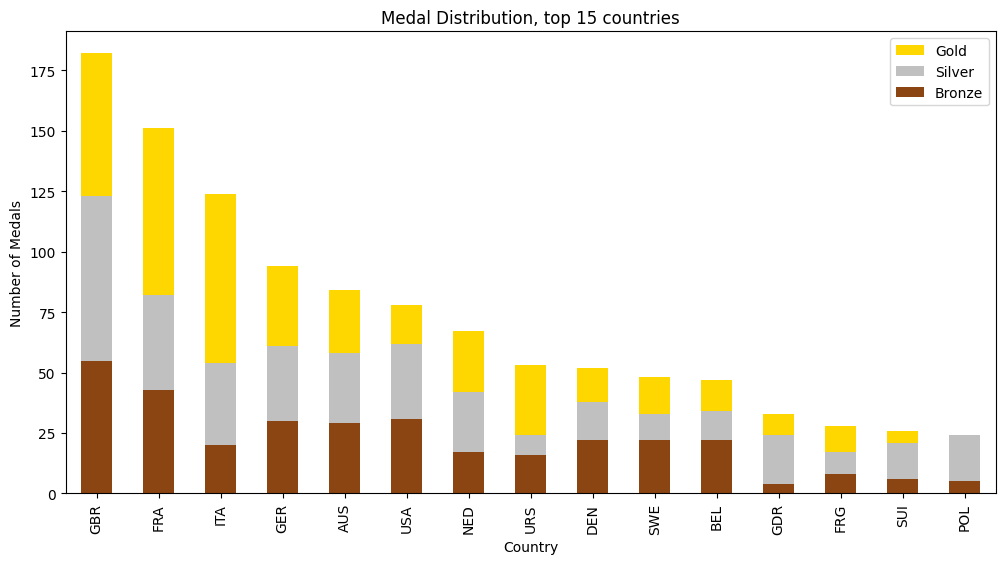

In [16]:
medal_distribution = cycling_df.groupby("NOC")["Medal"].value_counts().unstack().fillna(0)
medal_distribution = medal_distribution[["Gold", "Silver", "Bronze"]]

top_countries = medal_distribution.sum(axis=1).sort_values(ascending=False).head(15).index
medal_distribution_top = medal_distribution.loc[top_countries]

ax = medal_distribution_top[["Bronze", "Silver", "Gold"]].plot(
    kind="bar",
    stacked=True,
    title="Medal Distribution, top 15 countries",
    figsize=(12, 6),
    xlabel="Country",
    ylabel="Number of Medals",
    color=["saddlebrown", "silver", "gold"]
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

plt.show()

### Cycling medal distribution by age

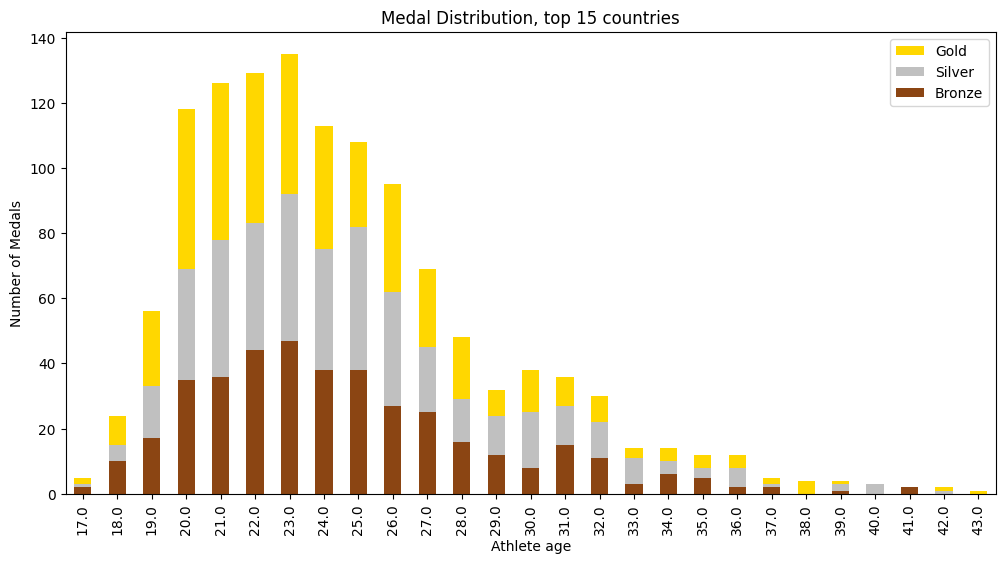

In [17]:
medal_distribution = cycling_df.groupby("Age")["Medal"].value_counts().unstack().fillna(0)
medal_distribution = medal_distribution[["Gold", "Silver", "Bronze"]]

top_ages = medal_distribution.sum(axis=1).index
medal_distribution_top = medal_distribution.loc[top_ages]

ax = medal_distribution_top[["Bronze", "Silver", "Gold"]].plot(
    kind="bar",
    stacked=True,
    title="Medal Distribution, top 15 countries",
    figsize=(12, 6),
    xlabel="Athlete age",
    ylabel="Number of Medals",
    color=["saddlebrown", "silver", "gold"]
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

plt.show()

### Cycling participant age distribution

<Axes: xlabel='Age'>

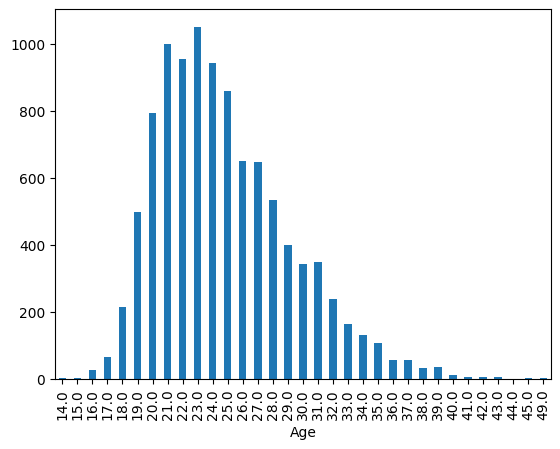

In [18]:
cycling_df.groupby('Age')["NOC"].count().plot.bar()